In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
#import statsmodels.api as sm


In [2]:
data1 = pd.read_csv("SML2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("SML2010/NEW-DATA-2.T15.txt", sep=' ')

In [3]:
data1.shape, data2.shape

((2764, 26), (1373, 26))

In [4]:
list(data1.columns)

['#',
 'Unnamed: 1',
 '1:Date',
 '2:Time',
 '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '17:Meteo_Exterior_Sol_Sud',
 '18:Meteo_Exterior_Piranometro',
 '19:Exterior_Entalpic_1',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor',
 '23:Humedad_Exterior_Sensor',
 '24:Day_Of_Week']

In [14]:
target = '3:Temperature_Comedor_Sensor'
cols = [
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [5]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [15]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [36]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))
y_his_train1 = np.zeros((len(data1), depth, 1))

In [37]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
for j in range(depth):
    y_his_train1[:, j, 0] = data1[target].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [38]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]
y_his_train1 = y_his_train1[depth:-prediction_horizon]

In [39]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))
y_his2 = np.zeros((len(data2), depth, 1))

In [40]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
for j in range(depth):
    y_his2[:, j, 0] = data2[target].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [41]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]
y_his_train2 = y_his2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]
y_his_val = y_his2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]
y_his_test = y_his2[train_size - len(data1) + val_size:]

In [42]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]
y_his_train2 = y_his_train2[depth:]

In [43]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)
y_his_train = np.concatenate([y_his_train1, y_his_train2], axis=0)

In [44]:
X_train.shape, y_train.shape, y_his_train.shape

((3179, 10, 16), (3179,), (3179, 10, 1))

In [45]:
X_train_min, y_train_min, y_his_train_min = X_train.min(axis=0), y_train.min(axis=0), y_his_train.min(axis=0)
X_train_max, y_train_max, y_his_train_max = X_train.max(axis=0), y_train.max(axis=0), y_his_train.max(axis=0)

In [46]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_his_train = (y_his_train - y_his_train_min)/(y_his_train_max - y_his_train_min + 1e-9)
y_his_val = (y_his_val - y_his_train_min)/(y_his_train_max - y_his_train_min + 1e-9)
y_his_test = (y_his_test - y_his_train_min)/(y_his_train_max - y_his_train_min + 1e-9)

In [48]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [49]:
train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [118]:
class InputAttentionEncoder(torch.jit.ScriptModule):
    
    __constants__ = ["M", "T", "N"]
    
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    @torch.jit.script_method
    def forward(self, inputs):
        
        encoded_inputs = torch.jit.annotate(List[Tensor], [])
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs += [h_tm1]
        encoded_inputs = torch.stack(encoded_inputs)
        encoded_inputs = encoded_inputs.permute(1, 0, 2)
        return encoded_inputs
    
class TemporalAttentionDecoder(torch.jit.ScriptModule):
    
    __constants__ = ["P", "T"]
    
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
    
    @torch.jit.script_method
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        c_t = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1
    
class DARNN(torch.jit.ScriptModule):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    
    @torch.jit.script_method
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [119]:
model = DARNN(X_train.shape[2], 128, 128, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [120]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [122]:
import time

Saving...
Iter:  0 train:  0.24193239867760455 val:  0.2595695581705056
Iter time:  1.3102287878282368
mse:  32.610157 mae:  4.70112


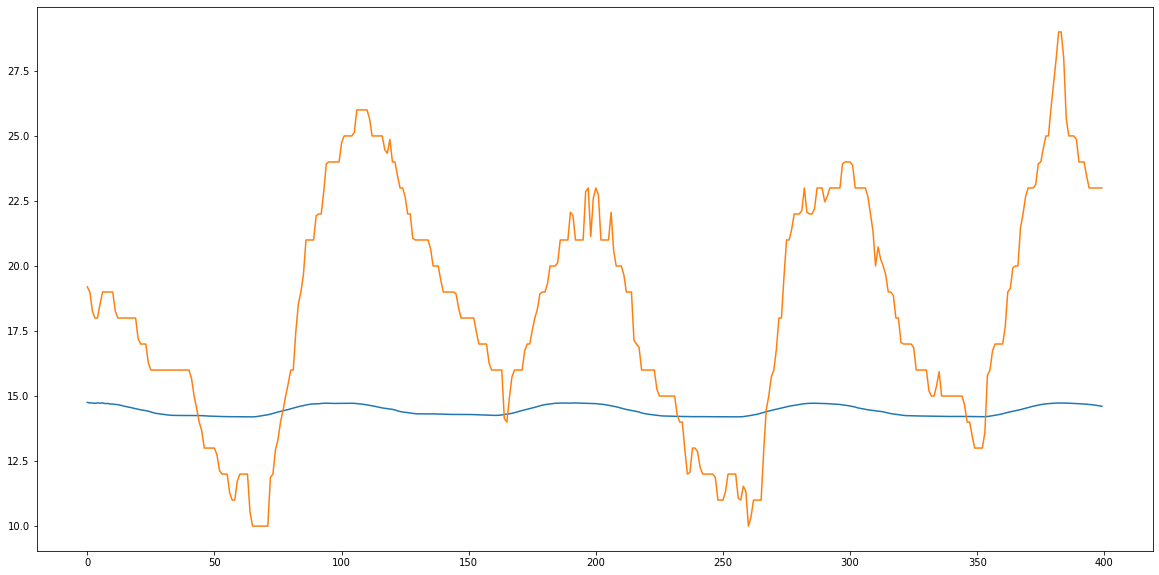

Saving...
Iter:  1 train:  0.18568517367627202 val:  0.22298140090948823
Iter time:  1.019806994125247
Saving...
Iter:  2 train:  0.14497554189004422 val:  0.12478009968243411
Iter time:  1.0562303340993822
Saving...
Iter:  3 train:  0.11622772843809472 val:  0.09908770445153761
Iter time:  1.208595722913742
Saving...
Iter:  4 train:  0.10231225215025654 val:  0.07977262477910933
Iter time:  1.2426120690070093
Saving...
Iter:  5 train:  0.06905102390324515 val:  0.05744497347945301
Iter time:  1.1535686110146344
Saving...
Iter:  6 train:  0.05130098620347728 val:  0.05293386757803537
Iter time:  1.2454513381235301
Saving...
Iter:  7 train:  0.04573086008434023 val:  0.04514283616444414
Iter time:  1.2226954153738916
Saving...
Iter:  8 train:  0.04451307751635845 val:  0.04431617680856313
Iter time:  1.1843813522718847
Iter:  9 train:  0.043359872128829344 val:  0.04511354821872885
Iter time:  1.1222390462644398
Saving...
Iter:  10 train:  0.04007987726518405 val:  0.04372458832208167
I

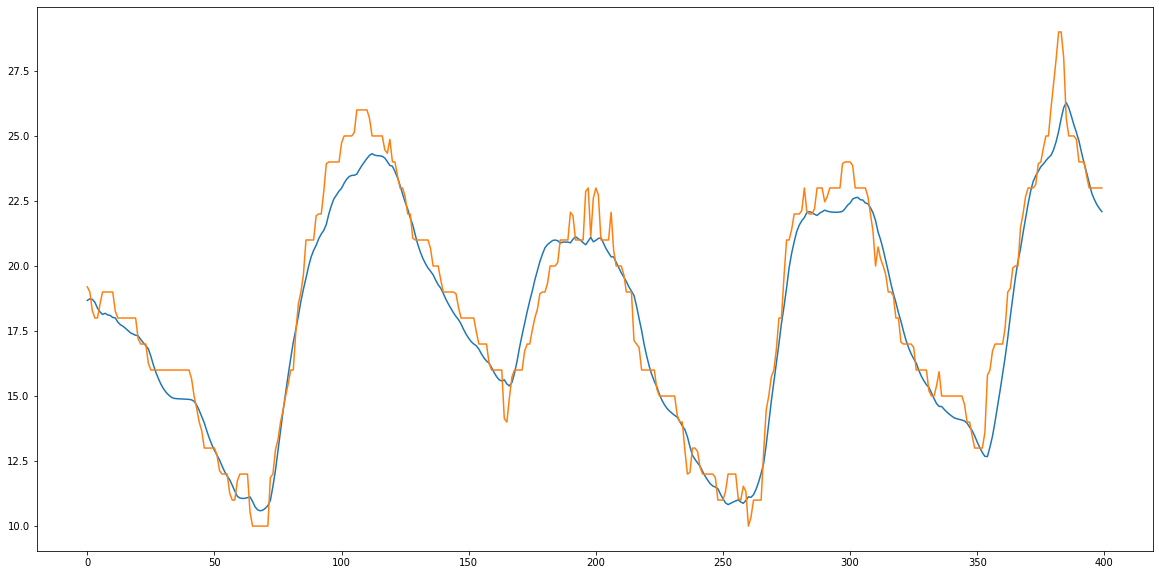

Saving...
Iter:  11 train:  0.039899635483149495 val:  0.04033216177385837
Iter time:  1.0574050908908248
Saving...
Iter:  12 train:  0.03615104030481483 val:  0.03917270985964446
Iter time:  1.0667407670989633
Iter:  13 train:  0.03509532823164359 val:  0.04215194961509234
Iter time:  1.0653788167983294
Saving...
Iter:  14 train:  0.03380073180644887 val:  0.03833816163662365
Iter time:  1.101644219364971
Saving...
Iter:  15 train:  0.03147107777246193 val:  0.03577629589418889
Iter time:  1.151255191769451
Saving...
Iter:  16 train:  0.029977504541398886 val:  0.031762910163381446
Iter time:  1.1159332362003624
Saving...
Iter:  17 train:  0.028926228864753215 val:  0.03135603201609606
Iter time:  1.0789336990565062
Iter:  18 train:  0.028061501105375822 val:  0.03202010388203756
Iter time:  1.1696074111387134
Iter:  19 train:  0.031359739356362826 val:  0.03308573362474557
Iter time:  1.154546368867159
Saving...
Iter:  20 train:  0.02790491248391526 val:  0.029707316322639236
Iter ti

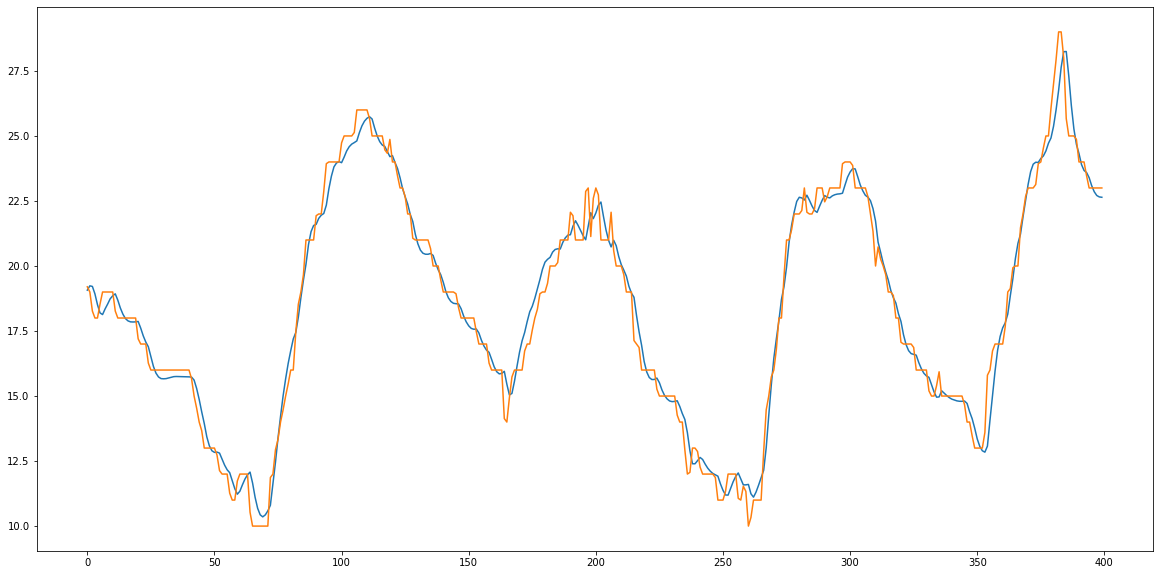

Iter:  21 train:  0.025844231870945825 val:  0.03322057055318422
Iter time:  1.296274095773697
Saving...
Iter:  22 train:  0.02591083814613263 val:  0.02958142535371065
Iter time:  1.1713201650418341
Iter:  23 train:  0.026647210016874753 val:  0.030037572077173755
Iter time:  1.1848659040406346
Saving...
Iter:  24 train:  0.025526409826626427 val:  0.02916632397342493
Iter time:  1.1283695581369102
Iter:  25 train:  0.025447424023372658 val:  0.03460625541870229
Iter time:  1.2296002297662199
Saving...
Iter:  26 train:  0.024726325403291192 val:  0.027970758997300196
Iter time:  1.1284603159874678
Saving...
Iter:  27 train:  0.024896283579654357 val:  0.027834183375489253
Iter time:  1.2035244987346232
Iter:  28 train:  0.02450191556456825 val:  0.02808434326013665
Iter time:  1.1103315008804202
Saving...
Iter:  29 train:  0.027670538064744198 val:  0.02729917179248058
Iter time:  1.1919415015727282
Iter:  30 train:  0.02600686980175038 val:  0.031172953861253114
Iter time:  1.0958343

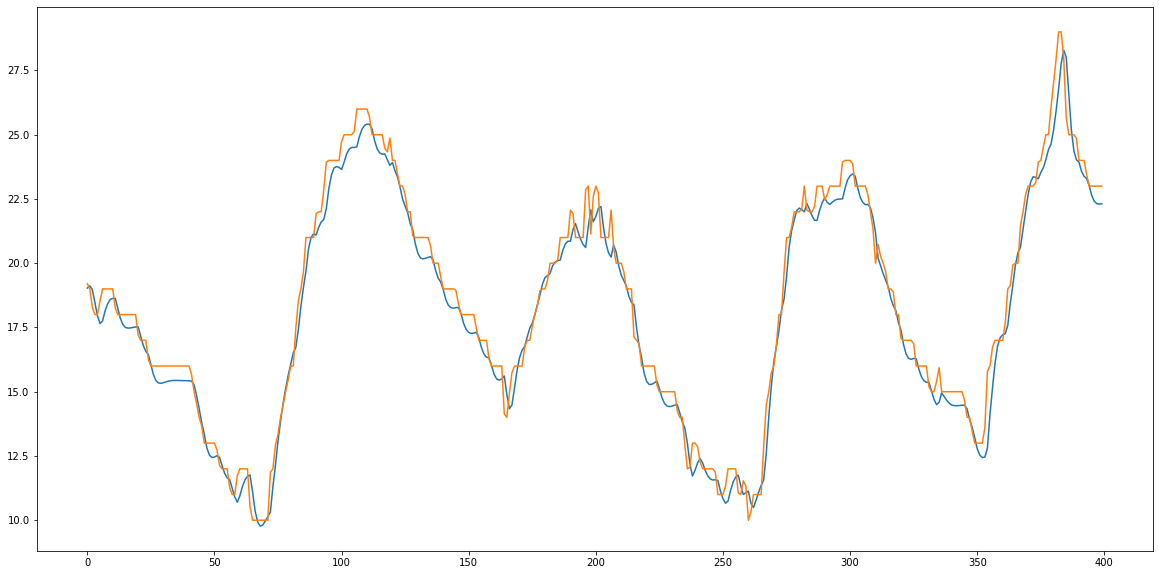

Saving...
Iter:  31 train:  0.025150672880715798 val:  0.027000669514392946
Iter time:  1.2066691750660539
Saving...
Iter:  32 train:  0.023185602070628798 val:  0.026905998203880475
Iter time:  1.1681452868506312
Saving...
Iter:  33 train:  0.024006463694992965 val:  0.026345752197645254
Iter time:  1.0804684096947312
Iter:  34 train:  0.024983880499188954 val:  0.028236676729763797
Iter time:  1.0816847132518888
Saving...
Iter:  35 train:  0.023275901493362196 val:  0.0260178091518459
Iter time:  1.0795590179041028
Saving...
Iter:  36 train:  0.022398642751793447 val:  0.025846428194428457
Iter time:  1.1064402707852423
Iter:  37 train:  0.022504281724662026 val:  0.025989315659718758
Iter time:  1.219619299750775
Saving...
Iter:  38 train:  0.022128138462258046 val:  0.025655231480587556
Iter time:  1.1498861350119114
Iter:  39 train:  0.02206350122642012 val:  0.027990692211854917
Iter time:  1.1720103449188173
Saving...
Iter:  40 train:  0.02164930910007013 val:  0.025282366382578

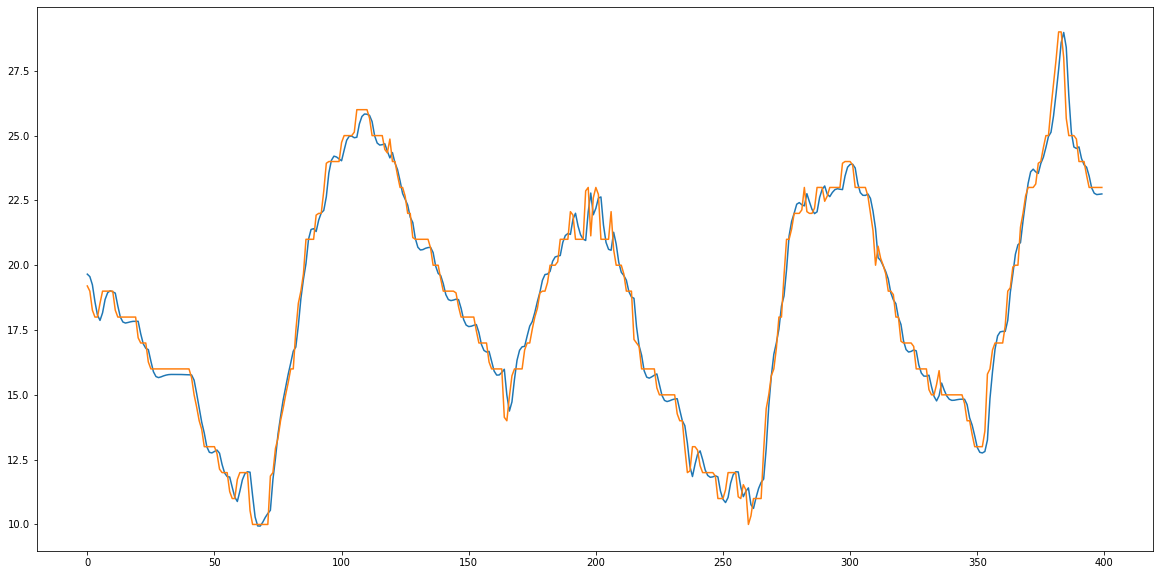

Iter:  41 train:  0.021537440374572135 val:  0.02643911291490961
Iter time:  1.2423447980545461
Iter:  42 train:  0.02329143149202136 val:  0.025643828197903215
Iter time:  1.2371322261169553
Iter:  43 train:  0.02144960084929762 val:  0.025727314415018066
Iter time:  0.9967360789887607
Saving...
Iter:  44 train:  0.021187055717723138 val:  0.024898595434339685
Iter time:  1.1548057338222861
Iter:  45 train:  0.022785642323733646 val:  0.025710315455866734
Iter time:  1.155890944879502
Saving...
Iter:  46 train:  0.02120679875278055 val:  0.024732711981733536
Iter time:  1.1788718537427485
Iter:  47 train:  0.020856144043634908 val:  0.025159206135244364
Iter time:  1.233370786998421
Saving...
Iter:  48 train:  0.02103959276593758 val:  0.02417593669225018
Iter time:  1.2228137250058353
Iter:  49 train:  0.021418463706454578 val:  0.025402840280233617
Iter time:  1.199712797999382
Saving...
Iter:  50 train:  0.02026718998802079 val:  0.02410877952068978
Iter time:  1.2322137379087508
m

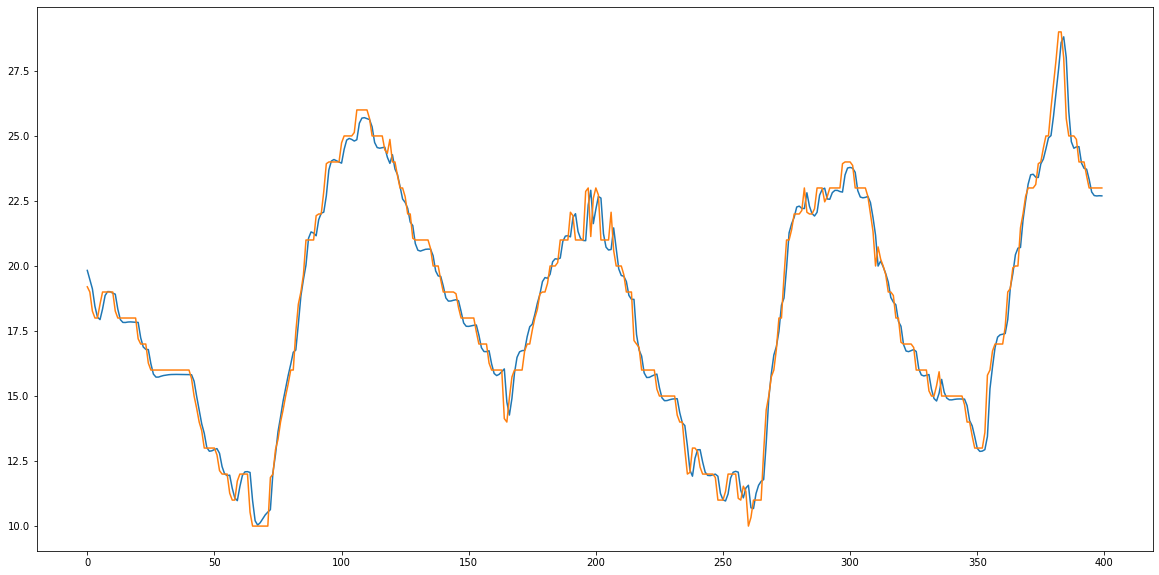

Saving...
Iter:  51 train:  0.021458181107716034 val:  0.023763958823185875
Iter time:  1.2279747501015663
Iter:  52 train:  0.021199760021914444 val:  0.024156261302055834
Iter time:  1.2204818641766906
Iter:  53 train:  0.019998668392086045 val:  0.02448036983717138
Iter time:  1.217142011038959
Saving...
Iter:  54 train:  0.02004649360089825 val:  0.02347970192954428
Iter time:  1.0761903887614608
Saving...
Iter:  55 train:  0.01975811955909604 val:  0.023221201698719173
Iter time:  1.1115849688649178
Iter:  56 train:  0.02059318531155514 val:  0.02545859061823016
Iter time:  1.1639081332832575
Iter:  57 train:  0.020155352628434382 val:  0.025456789995448988
Iter time:  1.0043381336145103
Saving...
Iter:  58 train:  0.019904108328581235 val:  0.023055304181968824
Iter time:  1.1894467831589282
Saving...
Iter:  59 train:  0.01978600447893838 val:  0.022946790049257485
Iter time:  1.070375102572143
Saving...
Iter:  60 train:  0.019269874260864052 val:  0.0227393620590825
Iter time:  

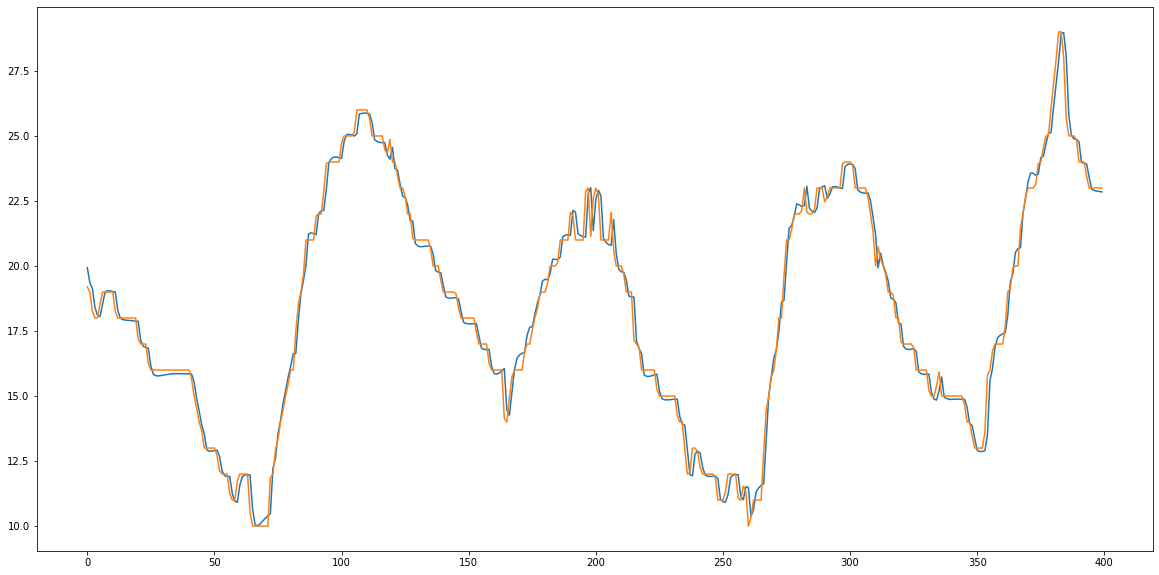

Iter:  61 train:  0.019479738387294446 val:  0.02453152200447825
Iter time:  1.1254761759191751
Iter:  62 train:  0.019030956242773612 val:  0.02332300921763292
Iter time:  1.1417312449775636
Iter:  63 train:  0.020180878024053644 val:  0.025121795979031625
Iter time:  1.1258740751072764
Iter:  64 train:  0.01894934012329303 val:  0.02418848654117553
Iter time:  1.0801845267415047
Iter:  65 train:  0.019349484806855076 val:  0.024462813436268382
Iter time:  1.13876643916592
Saving...
Iter:  66 train:  0.019045879744776555 val:  0.0224760459796466
Iter time:  1.1022425568662584
Iter:  67 train:  0.019359479717102085 val:  0.02577983787310573
Iter time:  1.1067920755594969
Iter:  68 train:  0.019906778061710963 val:  0.02464623954165248
Iter time:  1.1330242790281773
Iter:  69 train:  0.019760445235591065 val:  0.023390030970735633
Iter time:  1.0927905179560184
Saving...
Iter:  70 train:  0.01883952229680776 val:  0.022301530852643137
Iter time:  1.260543704032898
mse:  0.24072142 mae: 

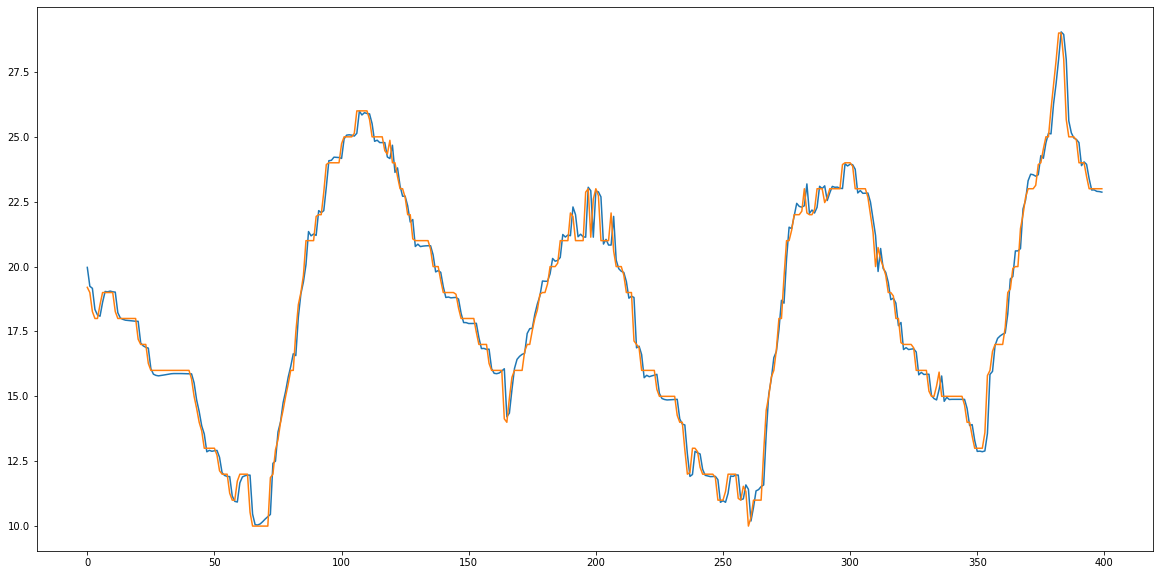

Iter:  71 train:  0.018794005065794612 val:  0.02245775604521619
Iter time:  1.242872801143676
Iter:  72 train:  0.018738112048726607 val:  0.0223248928428028
Iter time:  1.123482366092503
Iter:  73 train:  0.018659969452802683 val:  0.023935071348262667
Iter time:  1.1943884501233697
Iter:  74 train:  0.018900104128263432 val:  0.02288368292745542
Iter time:  1.074034791905433
Saving...
Iter:  75 train:  0.018545101843463613 val:  0.022179643722224255
Iter time:  1.0942129562608898
Iter:  76 train:  0.018734108514439112 val:  0.02224512139121929
Iter time:  1.093399804085493
Iter:  77 train:  0.019243040866671356 val:  0.023549508827117958
Iter time:  1.0986585831269622
Iter:  78 train:  0.019679552274142597 val:  0.023063782071095735
Iter time:  1.2310626744292676
Iter:  79 train:  0.018636317058465125 val:  0.024939766794867552
Iter time:  1.3692792570218444
Iter:  80 train:  0.019376402270513536 val:  0.022464609467928612
Iter time:  1.2080797087401152
mse:  0.24425472 mae:  0.3495

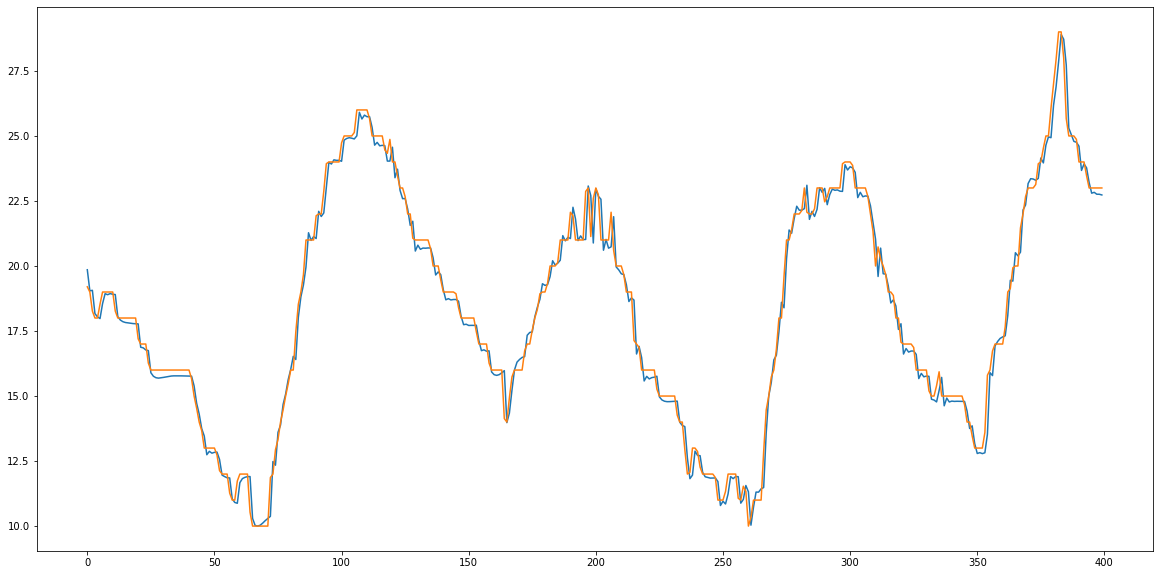

Iter:  81 train:  0.018346942455892447 val:  0.022218470510386158
Iter time:  1.1422226610593498
Iter:  82 train:  0.01829524545701086 val:  0.02235704370406932
Iter time:  1.1496712206862867
Saving...
Iter:  83 train:  0.018882908535839134 val:  0.022171209797901107
Iter time:  1.1140915961004794
Iter:  84 train:  0.018780475809668164 val:  0.02605685591789248
Iter time:  1.2825734140351415
Iter:  85 train:  0.02000920935446976 val:  0.022565075430307877
Iter time:  1.0413340949453413
Iter:  86 train:  0.018437857869922365 val:  0.022216349743965292
Iter time:  1.1469011381268501
Iter:  87 train:  0.018380048243097937 val:  0.02279035571237513
Iter time:  1.179862945806235
Iter:  88 train:  0.018647061911817406 val:  0.02332677245722402
Iter time:  1.1840151804499328
Iter:  89 train:  0.01931102955774697 val:  0.023916821310460846
Iter time:  1.2366626588627696
Iter:  90 train:  0.0203778583609431 val:  0.022605491220002636
Iter time:  1.0076018208637834
mse:  0.24732795 mae:  0.35713

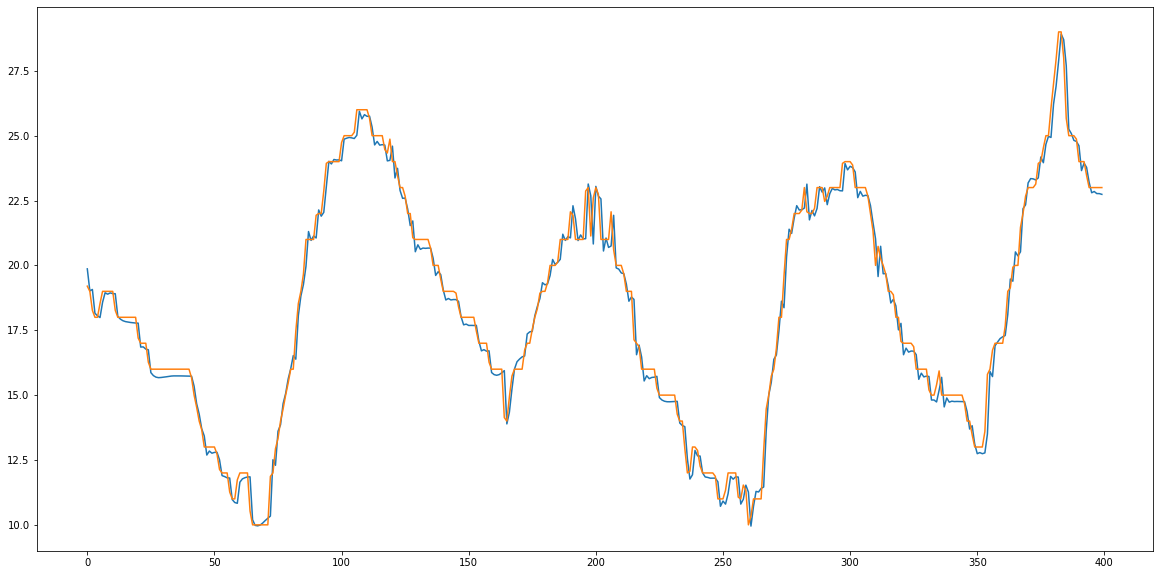

Iter:  91 train:  0.01927837671027101 val:  0.022240101622251193
Iter time:  1.0596396550536156
Iter:  92 train:  0.018826825963891857 val:  0.024984216084639896
Iter time:  1.0651149922050536
Iter:  93 train:  0.019470899898750137 val:  0.025846625113648526
Iter time:  1.0627941288985312
Iter:  94 train:  0.018952621905651713 val:  0.023890417296908238
Iter time:  1.0643772762268782
Iter:  95 train:  0.01851346500938444 val:  0.022317172809197514
Iter time:  1.0634986297227442
Iter:  96 train:  0.01872874004611703 val:  0.022390261610117687
Iter time:  1.136190330144018
Iter:  97 train:  0.019508330194862263 val:  0.022752376328962293
Iter time:  1.0635967659763992


In [123]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y_h, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [124]:
model.load_state_dict(torch.load("darnn_sml2010.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [125]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [126]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [127]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [128]:
mse, mae

(0.14463903, 0.27424285)

In [129]:
mse**0.5

0.38031438323959704

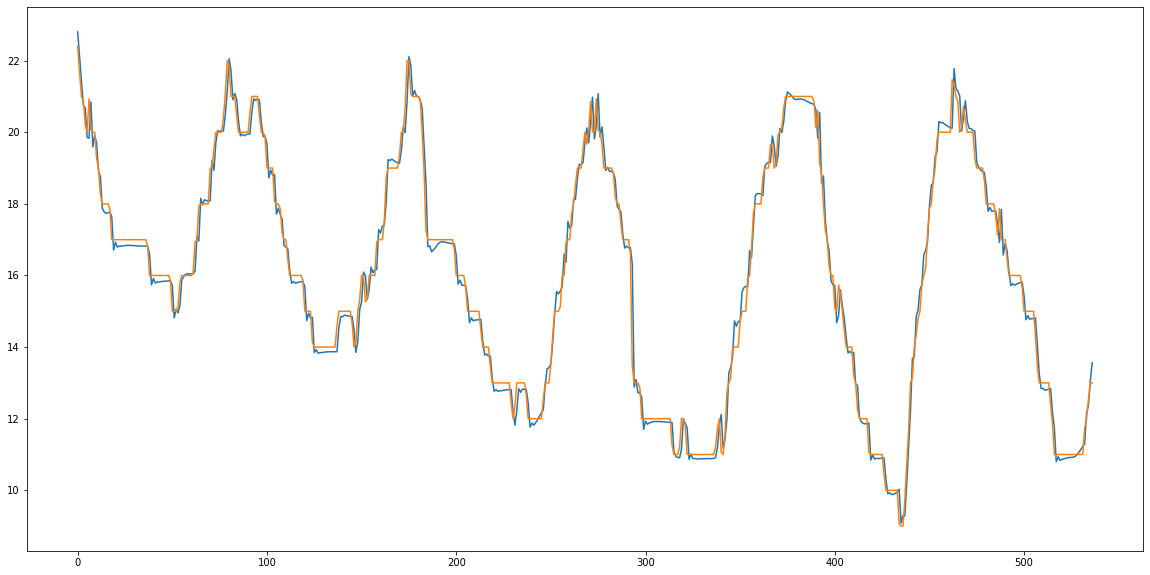

In [130]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()